In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [264]:
def data_generator(sample_size: int,
                   err_val: int=None) -> pd.DataFrame:
    '''Создаем синтетический датасет'''

    feature_A = 20 * np.random.randn(sample_size) + 100
    feature_B = 30 * np.random.randn(sample_size) + 200
    feature_C = 5 * np.random.randn(sample_size) + 20

    result = 2 * feature_A \
             + 8 * feature_B \
             + feature_C \
             + 25 * np.random.randn(sample_size) + 30

    df = pd.DataFrame({
        'A': feature_A,
        'B': feature_B,
        'C': feature_C,
        'Y': result})

    if err_val:
        idx = np.random.randint(0, sample_size, round(sample_size * 0.1))
        df.loc[idx, 'B'] = df.loc[idx, 'B'] * err_val

    return df

**Создаем три датасета с качественными данными**

In [265]:
df_1 = data_generator(10000)
df_2 = data_generator(50000)
df_3 = data_generator(10000)

**Создаем один "косячный" датасет**

In [266]:
df_err = data_generator(3000, 2)

**Сохраняем выборки на диск**

In [267]:
df_1.to_csv('./Data/dataset_1.csv', index=False)
df_2.to_csv('./Data/dataset_2.csv', index=False)
df_3.to_csv('./Data/dataset_3.csv', index=False)
df_err.to_csv('./Data/dataset_err.csv', index=False)

**Рисуем один нормальный датасет**

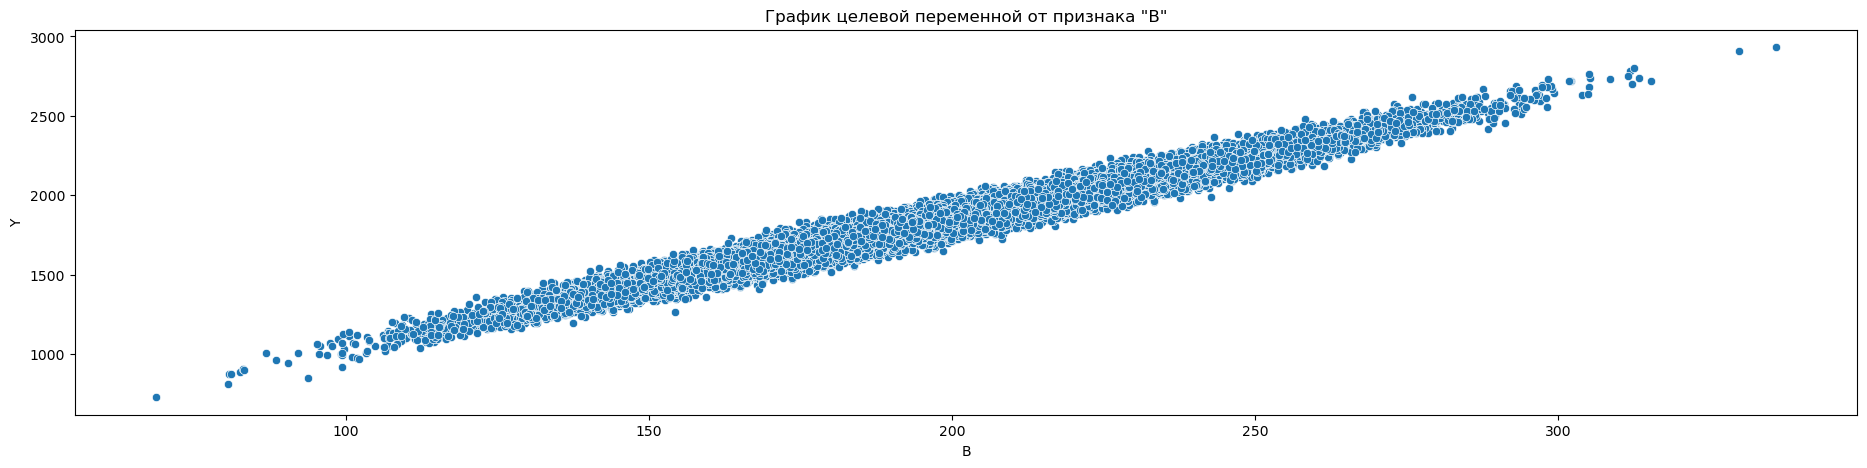

In [268]:
fig = plt.figure(figsize=(23, 5))

scat_plot = sns.scatterplot(data=df_2, 
                            x='B', 
                            y='Y');

scat_plot.set_title('График целевой переменной от признака "B"');

**И один "косячный" датасет**

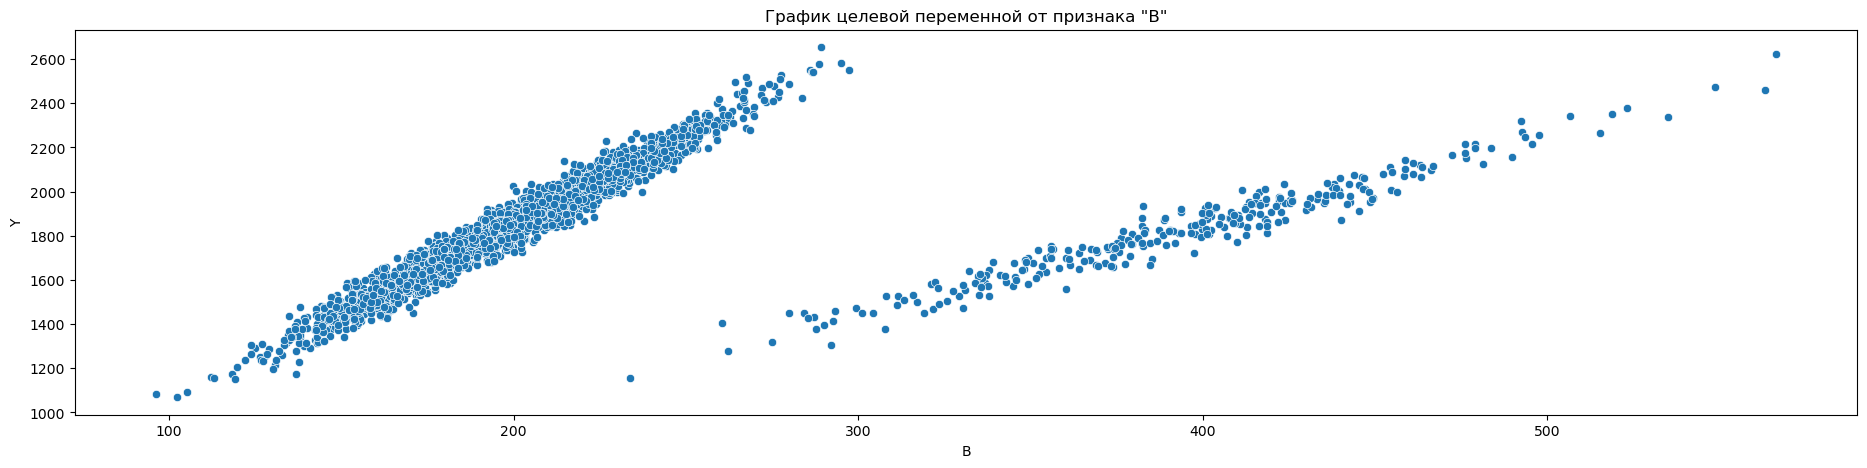

In [269]:
fig = plt.figure(figsize=(23, 5))

scat_plot = sns.scatterplot(data=df_err, 
                            x='B', 
                            y='Y');

scat_plot.set_title('График целевой переменной от признака "B"');

**Учим модель на датасете №2**

In [270]:
from sklearn.linear_model import LinearRegression

In [271]:
train_y = df_2['Y']
train_X = df_2.drop('Y', axis=1)

In [272]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

**Сохраняем модель**

In [273]:
pkl_filename = 'model.pkl'
with open(pkl_filename, 'wb') as file_:
    pickle.dump(model, file_)

**Тестируем модель на датасете №№1, 3**

In [274]:
test_y = df_1['Y']
test_X = df_1.drop('Y', axis=1)

model.score(test_X, test_y)

0.9894867963669459

In [275]:
test_y = df_3['Y']
test_X = df_3.drop('Y', axis=1)

model.score(test_X, test_y)

0.9894504053061355

**Пробуем метрику на "косячном" датасете (любопытства ради)**

In [276]:
test_y = df_err['Y']
test_X = df_err.drop('Y', axis=1)

model.score(test_X, test_y)

-3.349695996760408

==> Вывод: порог метрики можно смело установить на 0.98, чтобы всё, что ниже, не проходило тесты.

**Пробуем другие способы найти проблемы в датасете**

In [277]:
df_2.describe()

,A,B,C,Y
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,100.029080,199.929264,20.039259,1849.520815
std,19.984105,30.026367,5.027135,244.894278
min,9.623010,68.613455,-0.203102,729.400810
25%,86.495725,179.845677,16.603783,1686.122339
50%,100.134768,200.018612,20.027596,1849.997272
75%,113.468738,220.197980,23.426112,2014.292366
max,182.436363,335.971749,40.925573,2932.236902


/tmp/ipykernel_26310/2888291005.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_2.B)


<Axes: xlabel='B', ylabel='Density'>

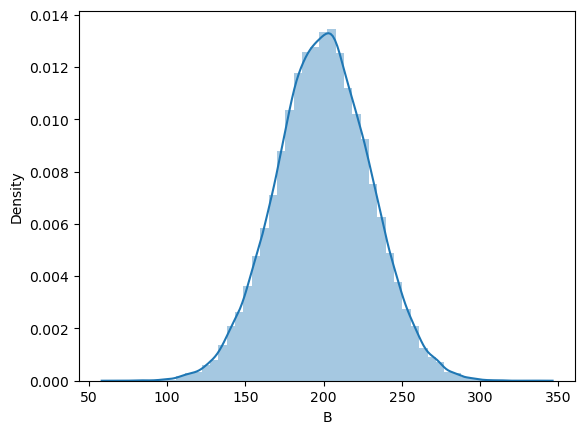

In [278]:
sns.distplot(df_2.B)

In [279]:
df_err.describe()

,A,B,C,Y
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,100.045932,218.053346,20.037048,1845.869080
std,20.300103,65.525567,4.977016,235.039819
min,35.926483,96.178168,3.168899,1068.888400
25%,86.022851,182.262321,16.635696,1690.915179
50%,100.463233,203.582714,20.179848,1851.046921
75%,113.495147,226.816605,23.392038,2000.662524
max,161.394195,566.466626,37.420778,2654.039675


/tmp/ipykernel_26310/444811246.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_err.B)


<Axes: xlabel='B', ylabel='Density'>

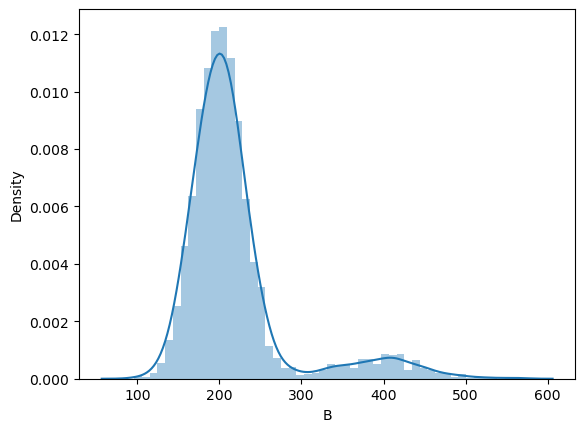

In [280]:
sns.distplot(df_err.B)

Созданный нами "косяк" лучше всего отследить через дисперсию и выбросы, чем через другие параметры распределения.

**Промежуточный вывод:**

Отлавливать ошибку будем:
1. Падением метрики по исследуемой выборке ниже 0.98;
2. Изменением параметра std выборки;
3. Можно также по изменению максимума/минимума

**Пишем тесты**

З.Ы. может и зря я так извращался с перебором всех файлов в директории, надо было наверное просто чтение чётырех созданных файлов сделать. Но уж раз сделал не стирать же теперь.

In [281]:
%%writefile 'test_datasets.py' 

import pytest
import os
import pandas as pd
import pickle


datasets = {}
files = os.listdir('./Data/')
for df_file in files:
    print(df_file)
    datasets[df_file] = pd.read_csv('./Data/' + df_file)

pkl_filename = 'model.pkl'
with open(pkl_filename, 'rb') as file_:
    model = pickle.load(file_)


def test_metric_crash():
    '''Тестируем метрику'''
    for dataset in datasets.keys():
        test_y = datasets[dataset]['Y']
        test_X = datasets[dataset].drop('Y', axis=1)
        assert model.score(test_X, test_y) > 0.98


def test_std():
    '''Тестируем дисперсию'''
    for dataset in datasets.keys():
        assert datasets[dataset]['B'].describe()['std'] < 50


def test_median():
    '''Ну и медиану, чтобы хоть один тест прошёл для примера'''
    for dataset in datasets.keys():
        assert 150 < datasets[dataset]['B'].describe()['50%'] < 300

Overwriting test_datasets.py


In [282]:
!pytest -v

============================= test session starts ==============================
platform linux -- Python 3.10.11, pytest-7.3.1, pluggy-1.0.0 -- /home/yarolit/anaconda3/envs/MOMO/bin/python
cachedir: .pytest_cache
rootdir: /home/yarolit/mlops_practice/lab5
plugins: anyio-3.6.2
collected 3 items                                                              

test_datasets.py::test_metric_crash FAILED                               [ 33%]
test_datasets.py::test_std FAILED                                        [ 66%]
test_datasets.py::test_median PASSED                                     [100%]

=================================== FAILURES ===================================
______________________________ test_metric_crash _______________________________

    def test_metric_crash():
        '''Тестируем метрику'''
        for dataset in datasets.keys():
            test_y = datasets[dataset]['Y']
            test_X = datasets[dataset].drop('Y', axis=1)
>           assert model.score(test

**Удаляем "косячный" файл**

In [283]:
import os

os.remove('./Data/dataset_err.csv')

**И снова запускаем pytest**

In [284]:
!pytest -v

============================= test session starts ==============================
platform linux -- Python 3.10.11, pytest-7.3.1, pluggy-1.0.0 -- /home/yarolit/anaconda3/envs/MOMO/bin/python
cachedir: .pytest_cache
rootdir: /home/yarolit/mlops_practice/lab5
plugins: anyio-3.6.2
collected 3 items                                                              

test_datasets.py::test_metric_crash PASSED                               [ 33%]
test_datasets.py::test_std PASSED                                        [ 66%]
test_datasets.py::test_median PASSED                                     [100%]

============================== 3 passed in 0.57s ===============================


**На этом всё**

З.Ы. Я "косячный" датасет снова положил в папку, чтобы было видно, что я его создавал вообще. Но если делать "прогон" этого ноутбука и не скопировать его отдельно, он будет удалён перед финальным пайтестом.